In [13]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

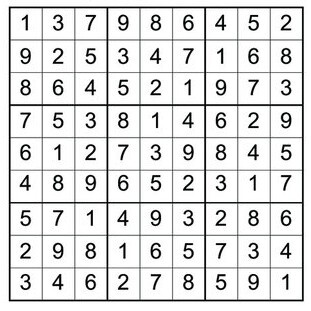

In [14]:
img = cv.imread("/content/cv.jpeg")
cv2_imshow(img)

In [15]:
img.shape

(311, 311, 3)

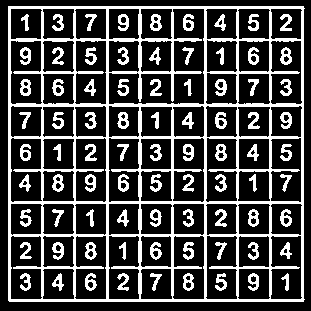

In [16]:
# Convert to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv.GaussianBlur(gray, (5, 5), 0)

# Adaptive Thresholding to reveal the grid
thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv.THRESH_BINARY, 11, 2)

# Invert colors to match MNIST format
thresh = cv.bitwise_not(thresh)

cv2_imshow(thresh)


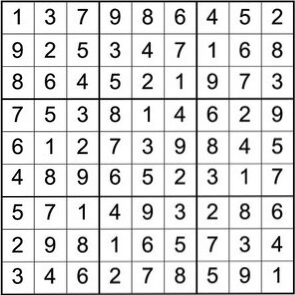

In [17]:
# Find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True)

# Find the largest 4-point contour
for cnt in contours:
    approx = cv.approxPolyDP(cnt, 0.02*cv.arcLength(cnt, True), True)
    if len(approx) == 4:
        grid_cnt = approx
        break

# Order the corners (Top-left, Top-right, Bottom-right, Bottom-left)
def order_points(pts):
    pts = pts.reshape(4, 2)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    return np.array([pts[np.argmin(s)], pts[np.argmin(diff)],
                     pts[np.argmax(s)], pts[np.argmax(diff)]], dtype='float32')

pts1 = order_points(grid_cnt)
side = max([
    np.linalg.norm(pts1[0] - pts1[1]),
    np.linalg.norm(pts1[1] - pts1[2]),
    np.linalg.norm(pts1[2] - pts1[3]),
    np.linalg.norm(pts1[3] - pts1[0])
])
pts2 = np.array([[0,0], [side-1,0], [side-1,side-1], [0,side-1]], dtype='float32')

# Perspective transform
M = cv.getPerspectiveTransform(pts1, pts2)
warped = cv.warpPerspective(gray, M, (int(side), int(side)))

cv2_imshow(warped)


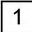

In [18]:
# Each cell size
cell_size = int(side / 9)
cells = []

# Extract 81 cells
for row in range(9):
    for col in range(9):
        x_start = col * cell_size
        y_start = row * cell_size
        cell = warped[y_start:y_start+cell_size, x_start:x_start+cell_size]
        cells.append(cell)

# Show a sample cell
cv2_imshow(cells[0])  # Top-left cell


In [19]:
processed_digits = []

for i, cell in enumerate(cells):
    # Apply adaptive threshold to isolate digit
    thresh_cell = cv.adaptiveThreshold(cell, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv.THRESH_BINARY_INV, 11, 2)

    # Find contours inside the cell
    contours, _ = cv.findContours(thresh_cell, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter based on area to skip noise / blank cells
    digit_img = None
    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)
        if w * h > 100:  # heuristic for "something is present"
            digit_img = thresh_cell[y:y+h, x:x+w]
            break

    if digit_img is not None:
        # Resize to MNIST 28x28
        digit_img = cv.resize(digit_img, (18, 18))  # slightly smaller, to pad later
        digit_img = np.pad(digit_img, ((5,5), (5,5)), "constant", constant_values=0)
        digit_img = digit_img / 255.0  # Normalize
        processed_digits.append(digit_img)
    else:
        processed_digits.append(None)  # Blank cell


In [20]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Simple CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

# Save model
model.save('mnist_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8859 - loss: 0.3770 - val_accuracy: 0.9779 - val_loss: 0.0677
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9787 - loss: 0.0689 - val_accuracy: 0.9808 - val_loss: 0.0566
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9862 - loss: 0.0445 - val_accuracy: 0.9855 - val_loss: 0.0460


In [21]:
from tensorflow.keras.models import load_model

# Load model
model = load_model('mnist_model.h5')

# Predict digits
predictions = []
for digit_img in processed_digits:
    if digit_img is None:
        predictions.append(0)  # or -1 to mark empty cells
    else:
        input_img = digit_img.reshape(1, 28, 28, 1)
        pred = model.predict(input_img, verbose=0)
        predictions.append(np.argmax(pred))

# Visualize results in 9x9 format
sudoku_matrix = np.array(predictions).reshape(9, 9)
print(sudoku_matrix)



[[0 3 7 9 8 5 4 5 2]
 [9 2 5 3 4 3 2 5 8]
 [8 9 4 5 2 2 9 3 3]
 [3 5 3 8 2 4 5 2 9]
 [5 2 2 7 3 9 8 2 5]
 [4 0 9 5 5 2 3 2 7]
 [5 2 0 4 9 3 2 8 5]
 [2 9 8 7 5 5 7 3 4]
 [3 4 5 2 3 3 5 9 2]]
